Dataset Loaded: (7043, 21)

NULL VALUES:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
ChurnFlag           0
dtype: int64


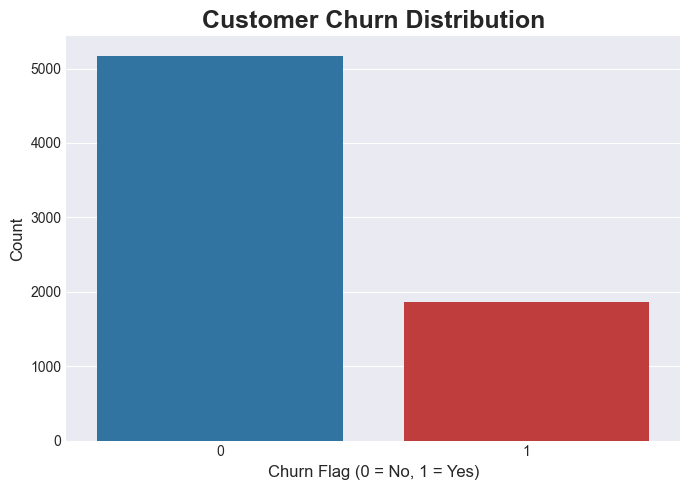

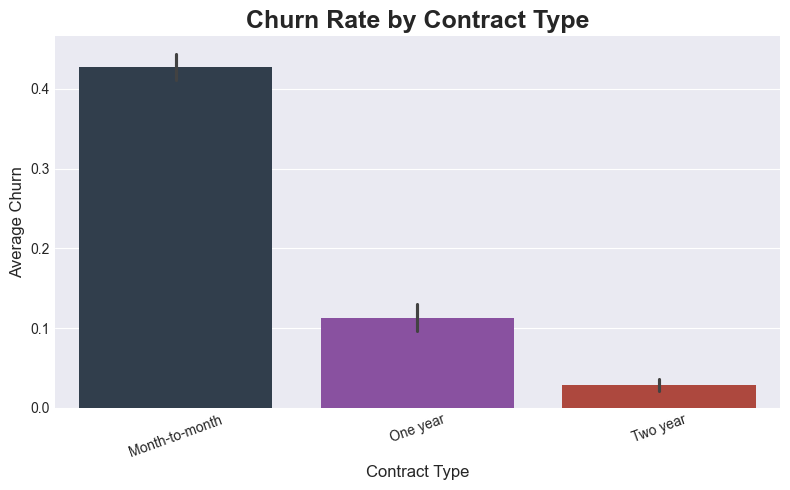

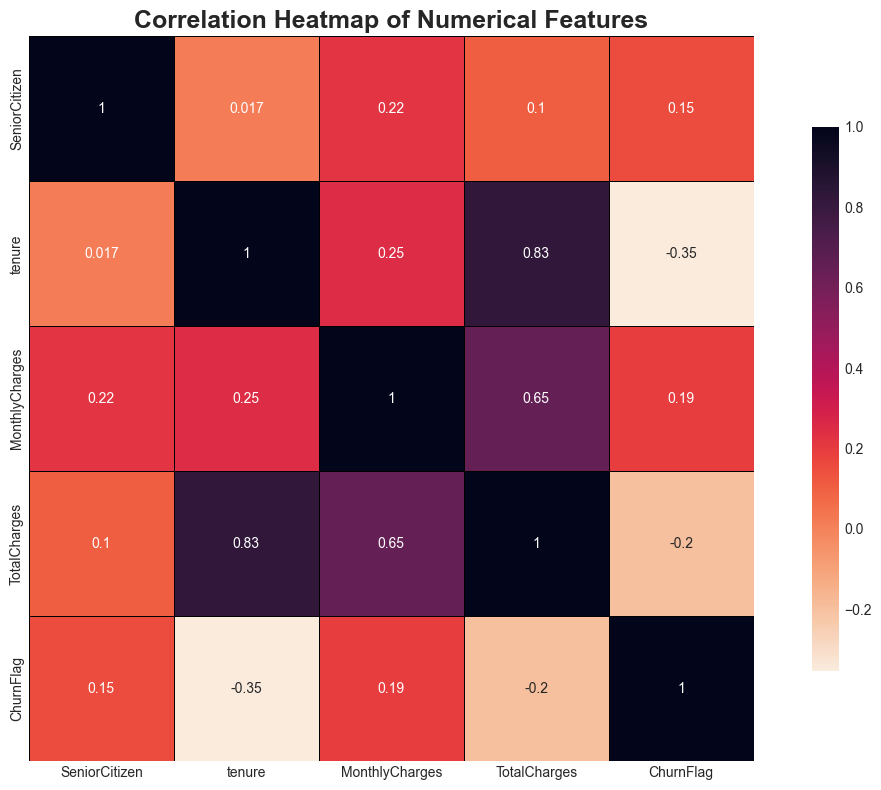


===== Logistic Regression Evaluation =====
Accuracy: 0.807495741056218
Precision: 0.6624365482233503
Recall: 0.5588865096359743
F1: 0.6062717770034843
ROC-AUC: 0.8465790057223423

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1294
           1       0.66      0.56      0.61       467

    accuracy                           0.81      1761
   macro avg       0.76      0.73      0.74      1761
weighted avg       0.80      0.81      0.80      1761



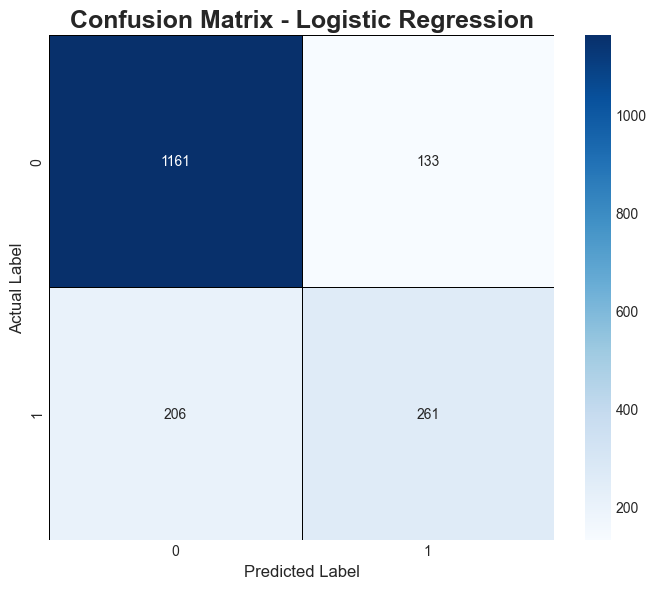


Model saved as churn_model.pkl


In [2]:
import pandas as pd
import numpy as np
import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import joblib
from datetime import datetime

# -------------------------------------------------------
# 1) LOAD DATA
# -------------------------------------------------------

df = pd.read_csv("customer_churn.csv")
print("Dataset Loaded:", df.shape)

# -------------------------------------------------------
# 2) CLEANING
# -------------------------------------------------------

df["TotalCharges"] = df["TotalCharges"].replace(" ", np.nan)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

df["ChurnFlag"] = df["Churn"].map({"Yes": 1, "No": 0})

customer_ids = df["customerID"]
df_model = df.drop(columns=["customerID"])

for col in df_model.columns:
    if df_model[col].dtype == object:
        df_model[col] = df_model[col].replace({
            "No internet service": "No",
            "No phone service": "No"
        })

print("\nNULL VALUES:")
print(df_model.isnull().sum())

# -------------------------------------------------------
# 3) VISUALIZATIONS (DARK THEME + NO WARNINGS)
# -------------------------------------------------------

plt.style.use("seaborn-v0_8-darkgrid")  # Dark & clean visual theme

# ---------- 1) Churn Distribution (Countplot) ----------
plt.figure(figsize=(7,5))

sns.countplot(
    data=df_model,
    x="ChurnFlag",
    hue="ChurnFlag",                # REQUIRED to avoid warning
    palette=["#1f77b4", "#d62728"], # deep blue, deep red
    legend=False
)

plt.title("Customer Churn Distribution", fontsize=18, fontweight="bold")
plt.xlabel("Churn Flag (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.show()


# ---------- 2) Churn vs Contract Type (Barplot) ----------
plt.figure(figsize=(8,5))

sns.barplot(
    data=df_model,
    x="Contract",
    y="ChurnFlag",
    hue="Contract",                 # REQUIRED to avoid warning
    palette=["#2c3e50", "#8e44ad", "#c0392b"],  # deep dark colors
    legend=False
)

plt.title("Churn Rate by Contract Type", fontsize=18, fontweight="bold")
plt.xlabel("Contract Type", fontsize=12)
plt.ylabel("Average Churn", fontsize=12)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


# ---------- 3) Correlation Heatmap ----------
numeric_df = df_model.select_dtypes(include=["int64", "float64"])

plt.figure(figsize=(12,8))
sns.heatmap(
    numeric_df.corr(),
    annot=True,
    cmap="rocket_r",      # Dark red–black color scheme
    linewidths=0.4,
    linecolor="black",
    cbar_kws={"shrink": 0.75},
    square=True
)

plt.title("Correlation Heatmap of Numerical Features", fontsize=18, fontweight="bold")
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# 4) FEATURES
# -------------------------------------------------------

X = df_model.drop(columns=["Churn", "ChurnFlag"])
y = df_model["ChurnFlag"]

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# -------------------------------------------------------
# 5) TRAIN-TEST SPLIT
# -------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# -------------------------------------------------------
# 6) TRAIN ONLY LOGISTIC REGRESSION
# -------------------------------------------------------

log_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

log_model.fit(X_train, y_train)

# -------------------------------------------------------
# 7) EVALUATION
# -------------------------------------------------------

y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:,1]

print("\n===== Logistic Regression Evaluation =====")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Plot (Enhanced)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(
    cm, annot=True, fmt="d",
    cmap="Blues",
    linewidths=0.5, linecolor="black"
)
plt.title("Confusion Matrix - Logistic Regression", fontsize=18, fontweight="bold")
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("Actual Label", fontsize=12)
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# 8) SAVE MODEL
# -------------------------------------------------------

joblib.dump(log_model, "churn_model.pkl")
print("\nModel saved as churn_model.pkl")



In [4]:
# -------------------------------------------------------
# 9) MYSQL CONNECTION
# -------------------------------------------------------

conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="khanna4658",
    database="telco_churn"
)
cursor = conn.cursor()
print("\nConnected to MySQL!")

# -------------------------------------------------------
# 10) FETCH ALL CUSTOMERS FROM SQL (without showing head)
# -------------------------------------------------------

cursor.execute("SELECT * FROM customers_raw")
rows = cursor.fetchall()

if len(rows) == 0:
    print("\n❗ No customer records found in customers_raw table.")
    cursor.close()
    conn.close()
    exit()

columns = [col[0] for col in cursor.description]
df_new = pd.DataFrame(rows, columns=columns)

print(f"\nFetched {len(df_new)} customers from SQL.")

# -------------------------------------------------------
# 11) PREDICT FOR ALL CUSTOMERS
# -------------------------------------------------------

df_pred = df_new.drop(columns=["customerID", "created_at"])
model = joblib.load("churn_model.pkl")

y_prob_all = model.predict_proba(df_pred)[:, 1]
y_pred_all = (y_prob_all >= 0.5).astype(int)

# -------------------------------------------------------
# 12) SAVE ALL PREDICTIONS BACK TO SQL
# -------------------------------------------------------

for cid, pred, prob in zip(df_new["customerID"], y_pred_all, y_prob_all):
    sql = """
    INSERT INTO churn_predictions (customerID, churn_predicted, churn_probability, predicted_at)
    VALUES (%s, %s, %s, %s)
    """
    cursor.execute(sql, (
        cid,
        int(pred),
        float(prob),
        datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    ))

conn.commit()
print("\n✅ All predictions saved to churn_predictions table.")


# -------------------------------------------------------
# 13) FUNCTION TO PREDICT CHURN FOR A SINGLE CUSTOMER
# -------------------------------------------------------

def predict_single_customer(customer_id):

    model = joblib.load("churn_model.pkl")

    # New cursor for reading customer
    cur = conn.cursor(buffered=True)
    cur.execute("SELECT * FROM customers_raw WHERE customerID = %s", (customer_id,))
    row = cur.fetchone()

    if row is None:
        print(f"\n❗ Customer ID '{customer_id}' not found in database.")
        return

    columns = [col[0] for col in cur.description]
    df_single = pd.DataFrame([row], columns=columns)
    df_input = df_single.drop(columns=["customerID", "created_at"])

    # Make prediction
    prob = model.predict_proba(df_input)[0][1]
    pred = int(prob >= 0.5)

    print("\n==============================")
    print(f"🔍 Prediction for Customer: {customer_id}")
    print("------------------------------")
    print(f"Churn Probability : {prob:.4f}")
    print(f"Predicted Churn   : {'YES' if pred == 1 else 'NO'}")
    print("==============================")

    # Check duplicate
    cur2 = conn.cursor(buffered=True)
    cur2.execute(
        "SELECT id FROM churn_predictions WHERE customerID = %s",
        (customer_id,)
    )
    exists = cur2.fetchone()

    if exists:
        print(f"\n⚠️ Prediction for '{customer_id}' already exists. Not inserting again.")
        return

    # Insert prediction
    cur3 = conn.cursor(buffered=True)
    sql_insert = """
        INSERT INTO churn_predictions (customerID, churn_predicted, churn_probability, predicted_at)
        VALUES (%s, %s, %s, %s)
    """
    cur3.execute(sql_insert, (
        customer_id,
        pred,
        float(prob),
        datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    ))

    conn.commit()
    print(f"\n✅ Prediction for '{customer_id}' saved to churn_predictions.")
# -------------------------------------------------------
# 14) TESTING — Predict Any Customer You Want
# -------------------------------------------------------
# 👉 Change the ID here to test any customer
predict_single_customer("0001-GIQMR")
predict_single_customer("0280-XJGEX")
predict_single_customer("6865-JZNKO")
predict_single_customer("5948-UJZLF")
predict_single_customer("1658-BYGOY")
cursor.close()
conn.close()


Connected to MySQL!

Fetched 7045 customers from SQL.

✅ All predictions saved to churn_predictions table.

🔍 Prediction for Customer: 0001-GIQMR
------------------------------
Churn Probability : 0.5755
Predicted Churn   : YES

⚠️ Prediction for '0001-GIQMR' already exists. Not inserting again.

🔍 Prediction for Customer: 0280-XJGEX
------------------------------
Churn Probability : 0.4347
Predicted Churn   : NO

⚠️ Prediction for '0280-XJGEX' already exists. Not inserting again.

🔍 Prediction for Customer: 6865-JZNKO
------------------------------
Churn Probability : 0.1167
Predicted Churn   : NO

⚠️ Prediction for '6865-JZNKO' already exists. Not inserting again.

🔍 Prediction for Customer: 5948-UJZLF
------------------------------
Churn Probability : 0.3073
Predicted Churn   : NO

⚠️ Prediction for '5948-UJZLF' already exists. Not inserting again.

🔍 Prediction for Customer: 1658-BYGOY
------------------------------
Churn Probability : 0.7848
Predicted Churn   : YES

⚠️ Prediction